In [3]:
import numpy as np
import pickle
import torch
from model import Transformer, Conv, Temporal_Conv_Transformer
from utils.prices_dataset import Prices
from utils.loss_functions import CustomLoss, SignWeightedLoss
from train_test import train, test, test_conf, test_conf_val, test_conf_time, test_mus_stds_tgts
import matplotlib.pyplot as plt

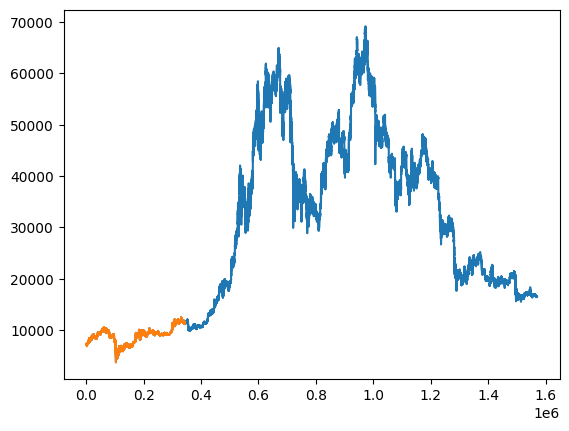

In [17]:
d1 = np.load("data/BINANCE_PERP_close.npy")
d2 = np.load("data/BINANCE_PERP_2023_close.npy")
plt.plot(d1)
plt.plot(d2)

In [18]:
test = "001"
print(int(test))

1


In [7]:
discrim = False
epoch = 3
lr = 0.001
feature_size = 9
num_layers = 1
dropout = 0.0
batch_size = 512
seq_length = 720
shift = 5
tgt_step = 30
reg_weight=10000000
center = True
norm =  False
#loss_func = SignWeightedLoss(weight=reg_weight)
loss_func = torch.nn.L1Loss(reduce=False, reduction='sum')
timeframe = "1m"

device = 'cuda' if torch.cuda.is_available() else 'cpu'


trainset = Prices("data/train{}.npy".format(timeframe), seq_length, shift=shift, center=center, norm=norm, tgt_step=tgt_step)
testset = Prices("data/test{}.npy".format(timeframe), seq_length, shift=shift, center=center, norm=norm, tgt_step=tgt_step)
model = Temporal_Conv_Transformer(seq_length = seq_length, feature_size=feature_size, dropout=dropout, num_layers=num_layers)
#trans_model = Transformer(seq_length = seq_length, feature_size=1, dropout=0.1)
#conv_model = Conv(seq_length = seq_length)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=0, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=0, shuffle=False, drop_last=True)


C:\Users\lenna\anaconda3\envs\rl-proj\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [8]:
PATH = f"model/pred_model_{timeframe}_len_{seq_length}_shift_{shift}_epoch_{epoch}_lr_{lr}.pt"
PATH = f"model/001.pt"
model.load_state_dict(torch.load(PATH, map_location=device))
model = model.to(device)

In [ ]:
a = "testo"
b = (-int(a=="test")+int(a!="test"))*10
print(b)

In [ ]:

s1, s2, s3, s4, s5, s6, s7, s8, s9  = "ID", "Open Time", "Close Time", "Side", "Open Price", "Close Price", "Close Type", "Result", "Capital Change"
with open("logs/test.txt", "a") as f:
    f.write("### START ### \n\n" + f"{s1:<15} | {s2:<15} | {s3:<15} | {s4:<15} | {s5:<15} | {s6:<15} | {s7:<15} | {s8:<15} | {s9:<15}")

In [9]:
take_profit = 0.2
stop_loss = -0.02
trailing_stop = 2*stop_loss
capital = 1000
invest = 0.15
fees = 0.0001
slip_prob = 1.0
slippage = 0.00000
spread = 0.00000
leverage=200

In [15]:
print(all_prices[0])

16543.67


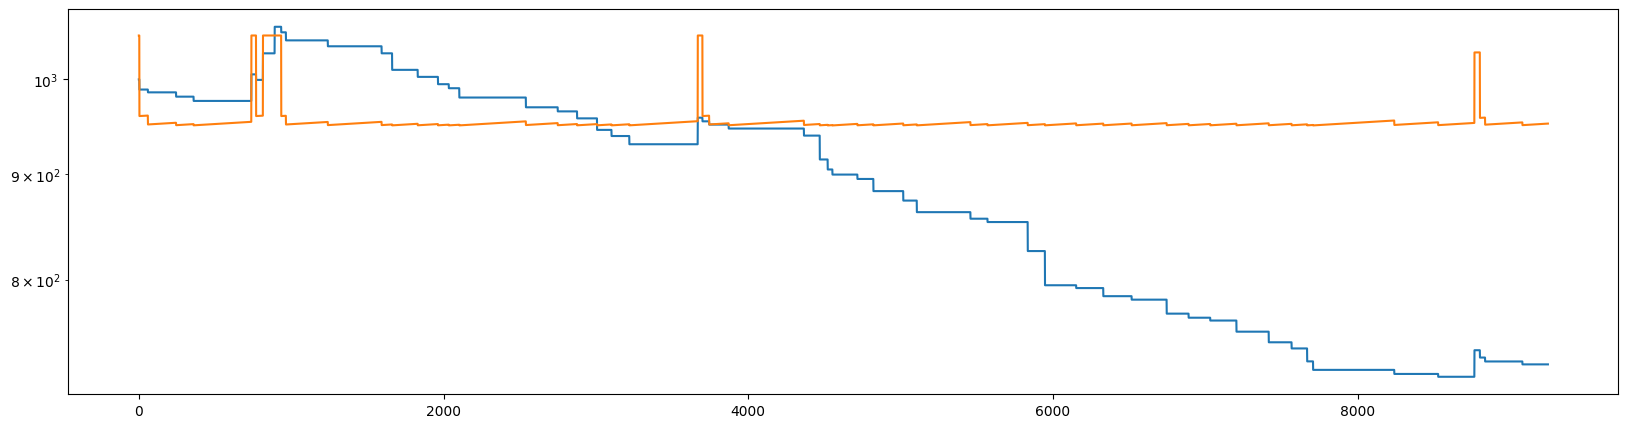


###
capital:  728.2624820578313
current pred dif:  tensor(443.5332)
p & l  6 52
p/l:  0.10344827586206896
total trades:  58 collision trades:  0


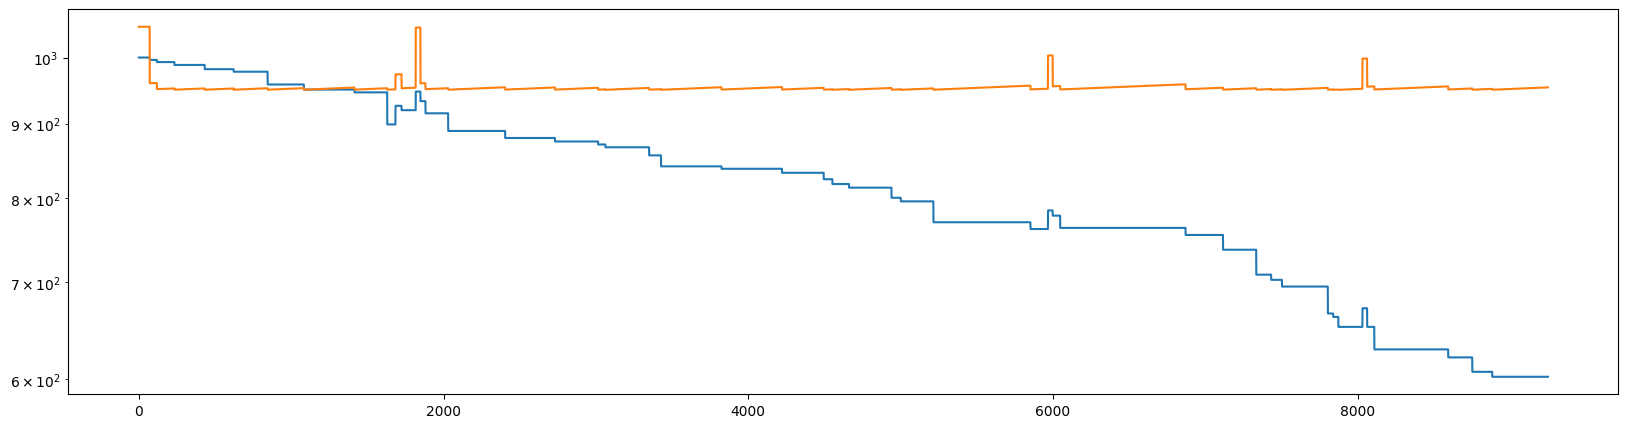


###
capital:  602.5474832464879
current pred dif:  tensor(1630.3613)
p & l  5 44
p/l:  0.10204081632653061
total trades:  49 collision trades:  0


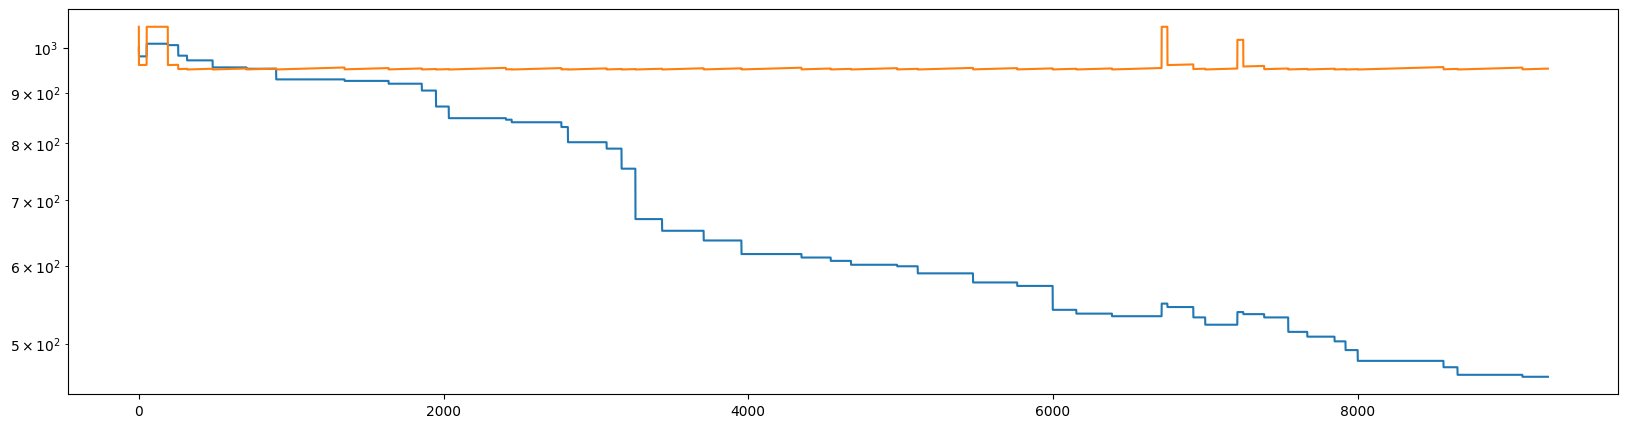


###
capital:  462.91636793359095
current pred dif:  tensor(2851.1035)
p & l  4 46
p/l:  0.08
total trades:  50 collision trades:  0


KeyboardInterrupt: 

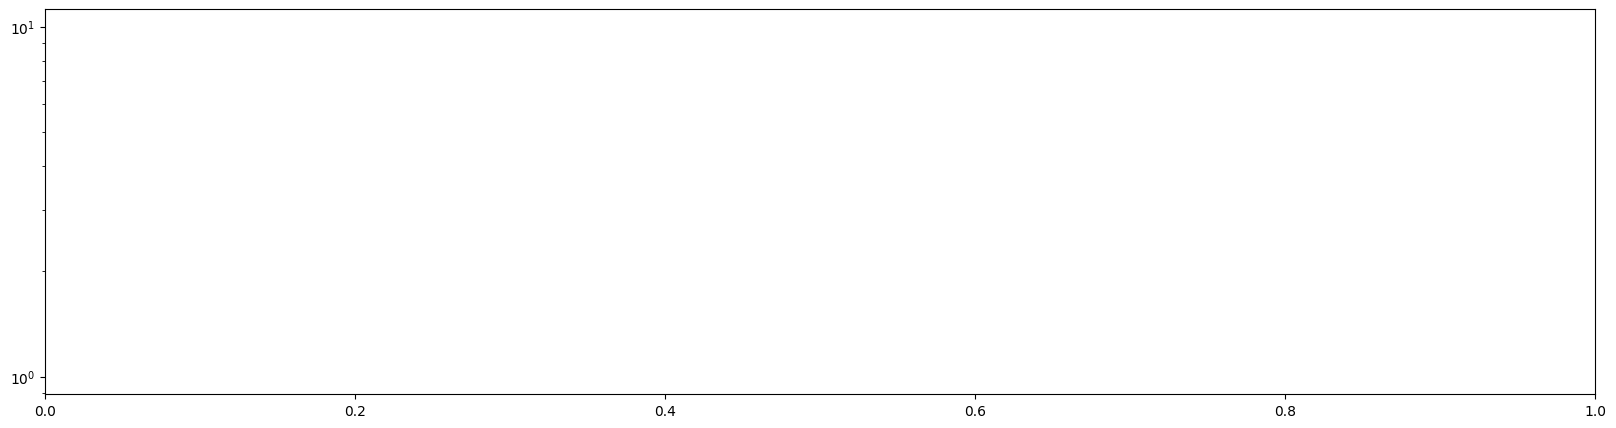

In [13]:
tstep=1
batch_size=1
testset = Prices("data/2023test{}m.npy".format(tstep), seq_length, shift=shift, center=center, norm=norm, tgt_step=tgt_step)
all_prices = np.load(f"data/2023test{tstep}m.npy")
all_prices_high = np.load(f"data/2023test{tstep}m_high.npy")
all_prices_low = np.load(f"data/2023test{tstep}m_low.npy")
duration  = len(all_prices)
duration = 1e4/tstep
tms = int(len(all_prices)/duration)
total_pred = 0 # sum change for correct predictions
ps = 0 # counter for correct predictions
fs = 0 # counter for incorect predictions
mx_mu = 10.8 # max mu from training/testing !!!MODEL SPECIFIC!!!
c = 0.25 # mu clip for 
cooldown_reset_p = int(30/tstep)
cooldown_reset_l = int(30/tstep)
miss_pen = 0.1
penalty_decay = 1e4
#cooldown_reset = 0
miss_counter = 0
miss_limit = 1
capitals_tt = []
prof_list = []
losses_list = []
trade_lens_p = []
trade_lens_l = []
side_p = 0
side_l = 0
for tt in range(tms):
    pos_price = 0
    pos = False
    side = 0
    capital = 1000
    trade_prob = 1
    profits = 1
    losses = 1
    cooldown = 0
    collisions = 0
    t_start = 0
    #tt = np.random.uniform(0,tms)
    prices = all_prices[int(tt*duration):int((tt+1)*duration)]
    prices_high = all_prices_high[int(tt*duration):int((tt+1)*duration)]
    prices_low = all_prices_low[int(tt*duration):int((tt+1)*duration)]
    capitals = []
    probs = []
    #testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=0, shuffle=False, drop_last=True)
    model.eval()
    draws = np.random.binomial(1,trade_prob,int(duration-tgt_step-seq_length))
    slips = np.random.binomial(1,slip_prob,int(duration-tgt_step-seq_length))
    for ii in range (int(duration-tgt_step-seq_length)):
        trade_prob += (1-trade_prob)/penalty_decay
        draw = np.random.binomial(1,trade_prob,1)
        price = prices[seq_length+ii]
        price_low = prices_low[seq_length+ii]
        price_high = prices_high[seq_length+ii]
        cooldown -=1
        #print(trade_prob)
        
        #print(price, pos_price, ((100*(price-pos_price))/pos_price), side)
        if pos:
            #print(pos_price)
            change = side*leverage*(price-pos_price)/pos_price
            if side>0:
                change_p = leverage*(price_low-pos_price)/pos_price
                change_l = leverage*(price_low-pos_price)/pos_price
            if side<0:
                change_p = -leverage*(price_high-pos_price)/pos_price
                change_l = -leverage*(price_high-pos_price)/pos_price
            overhead = capital*invest*(fees+leverage*(slippage+spread))
            #if change>=take_profit or change<=stop_loss:
                #print("profit/loss:", change)
                #print("overhead:", overhead)
            '''if change>=take_profit:
                capital = capital + change*capital*invest - overhead
                profits += 1
                pos = False
                side = 0
            if change <= stop_loss:
                capital = capital + change*capital*invest - overhead
                losses += 1
                pos = False
                side = 0'''
            if change_l<=stop_loss:
                capital = capital + ((slips[ii]*change_l)+(1-slips[ii])*stop_loss)*capital*invest - overhead
                #capital = capital + stop_loss*capital*invest - overhead
                pos = False
                trade_lens_l.append(ii-t_start)
                side_l += side
                side = 0
                miss = True
                trade_prob = trade_prob * miss_pen
                cooldown = cooldown_reset_l
                losses += 1
                losses_list.append((price-pos_price)/pos_price)
            elif change_p>=take_profit:
                capital = capital + ((slips[ii]*take_profit)+(1-slips[ii])*take_profit)*capital*invest - overhead
                #capital = capital + take_profit*capital*invest - overhead
                pos = False
                trade_lens_p.append(ii-t_start)
                cooldown = cooldown_reset_p
                side_p += side
                side = 0
                profits += 1
                miss_counter = False
                trade_prob = trade_prob * (3/miss_pen)
                miss_counter = min([miss_counter, 0])
                prof_list.append((price-pos_price)/pos_price)
            
            if change_p>=take_profit and change_l<=stop_loss:
                collisions +=1
            #print("position closed with: ", (side*(100*(price-pos_price)/pos_price))*capital*invest)
        if not pos and draw and cooldown<=0: #and ii%30==0:
            src = (torch.tensor(prices[ii:ii+seq_length]).unsqueeze(dim=0)-price).float()
            tgt = torch.tensor(prices[ii+seq_length+tgt_step]).float()-price
            eps = torch.zeros(src.size())
            with torch.no_grad():
                pred, mu, std = model(src, eps)
            if torch.abs(mu)>=c*mx_mu:# and torch.abs(std)>=c*mx_std:
                pos_price = prices[seq_length+ii]
                side = int(torch.sign(mu))
                pos = True
                t_start = ii
                if torch.sign(mu)==torch.sign(tgt):
                    total_pred += side*tgt
                    ps += 1
                else:
                    fs += 1
            '''side[pos] = np.random.binomial(1,0.5)*2-1
            pos_price[pos] = price
            pos +=1'''
        
        trade_prob = min(1,max(0,trade_prob))
        capitals.append(capital)
        probs.append(trade_prob)
        if (ii+1)%duration==0 or capital<=0:
            break
    plt.figure(figsize=(20,5))
    plt.yscale("log")
    plt.plot(capitals)
    plt.plot((np.asarray(probs)-0.5)*100+1000)
    plt.show()
    print("\n###")
    print("capital: ", capital)
    print("current pred dif: ", total_pred)
    capitals_tt.append(capital)
    print("p & l ", profits, losses)
    print("p/l: ", profits/(profits+losses))
    print("total trades: ", profits+losses, "collision trades: ", collisions)

In [ ]:
### accuracy
print(ps/(ps+fs))
print(ps,fs)
### capitals over time for each period
capitals_tt = np.asarray(torch.tensor(capitals_tt))
print(np.mean(capitals_tt), np.std(capitals_tt), np.median(capitals_tt))
print(np.min(capitals_tt), np.max(capitals_tt))
bins = [0,100, 500,1000,2000,5000,10000]
plt.hist(capitals_tt, bins=bins)
plt.show()
### total capital over time
capital = 1000
caps_ord = np.sort(capitals_tt)
total_capitals_tt = []
print(caps_ord)
for cs in capitals_tt:
    capital = capital*(cs/1000)
    total_capitals_tt.append(capital)
    print(capital)
print(capital)
plt.yscale("log")
plt.plot(total_capitals_tt)
plt.show()
### analyze length of trades
print(np.mean(trade_lens_p))
print(np.std(trade_lens_p))
print(np.median(trade_lens_p))
print(np.mean(trade_lens_l))
print(np.std(trade_lens_l))
print(np.median(trade_lens_l))

In [ ]:
print(np.random.binomial(1,1,1)[0])

In [ ]:
int(-7.0)

In [ ]:
bins = [0,1,2,3,4,5,10,100]
plt.xscale("log")
plt.hist(trade_lens_p, bins=bins)
plt.show()

print(np.min(trade_lens_p))
plt.xscale("log")
plt.hist(trade_lens_l, bins=bins)

In [ ]:
prof_list=np.asarray(prof_list)
print(np.mean(prof_list)*leverage)
print(np.max(prof_list)*leverage)
plt.hist(np.abs(np.asarray(prof_list))*leverage)
plt.show()
print(np.max(losses_list)*leverage)
plt.hist(np.abs(np.asarray(losses_list))*leverage)

In [ ]:
print(np.mean(prof_list)*leverage)

In [9]:
config = {
    "modelID" : "002",
    "sequenceLength" : 720,
    "tgtStep" : 30,
    "featureSize" : 9,
    "dropout" : 0.0,
    "numLayers" : 1,
    "takeProfit" : 0.2,
    "stopLoss" : -0.02,
    "trailingStopLoss" : -0.02,
    "invest" : 0.15,
    "leverage" : 200,
    "fees" : 0.0001,
    "spread" : 0.0000,
    "muClip" : 0.0,
    "stdClip" : 1.0,
    "maxMu" : 3.833,
    "maxStd" : 10,
    "penalty" : 0.5,
    "penaltyDecay" : 1e4,
    "cooldown_reset_p" : 30,
    "cooldown_reset_l" : 30
}

In [10]:
id = 1
file =  open(f"configs/tradeConfig_{id:05d}", "wb")
pickle.dump(config, file)
file.close()

In [11]:
config = {
    "modelID" : "002",
    "sequenceLength" : 720,
    "tgtStep" : 30,
    "featureSize" : 9,
    "dropout" : 0.0,
    "numLayers" : 1,
    "takeProfit" : 0.2,
    "stopLoss" : -0.02,
    "trailingStopLoss" : -0.02,
    "invest" : 0.15,
    "leverage" : 200,
    "fees" : 0.0001,
    "spread" : 0.0000,
    "muClip" : 0.5,
    "stdClip" : 1.0,
    "maxMu" : 3.9875,
    "maxStd" : 0.3848,
    "penalty" : 0.5,
    "penaltyDecay" : 1e4,
    "cooldown_reset_p" : 30,
    "cooldown_reset_l" : 30
}

In [12]:
id = 2
file =  open(f"configs/tradeConfig_{id:05d}", "wb")
pickle.dump(config, file)
file.close()

In [13]:
config = {
    "modelID" : "005",
    "sequenceLength" : 720,
    "tgtStep" : 30,
    "featureSize" : 9,
    "dropout" : 0.0,
    "numLayers" : 1,
    "takeProfit" : 0.2,
    "stopLoss" : -0.02,
    "trailingStopLoss" : -0.02,
    "invest" : 0.15,
    "leverage" : 200,
    "fees" : 0.0001,
    "spread" : 0.0000,
    "muClip" : 0.95,
    "stdClip" : 1.0,
    "maxMu" : 5.26,
    "maxStd" : 1.26,
    "penalty" : 0.5,
    "penaltyDecay" : 1e4,
    "cooldown_reset_p" : 30,
    "cooldown_reset_l" : 30
}

In [14]:
id = 3
file =  open(f"configs/tradeConfig_{id:05d}", "wb")
pickle.dump(config, file)
file.close()

In [21]:
config = {
    "modelID" : "006",
    "sequenceLength" : 720,
    "tgtStep" : 30,
    "featureSize" : 9,
    "dropout" : 0.0,
    "numLayers" : 1,
    "takeProfit" : 0.2,
    "stopLoss" : -0.02,
    "trailingStopLoss" : -0.02,
    "invest" : 0.15,
    "leverage" : 200,
    "fees" : 0.0001,
    "spread" : 0.0000,
    "muClip" : 0.5,
    "stdClip" : 10.0,
    "maxMu" : 4.5639,
    "maxStd" : 1.26,
    "penalty" : 0.5,
    "penaltyDecay" : 1e3,
    "cooldown_reset_p" : 0,
    "cooldown_reset_l" : 30
}

In [22]:
id = 4
file =  open(f"configs/tradeConfig_{id:05d}", "wb")
pickle.dump(config, file)
file.close()

In [79]:
config = {
    "modelID" : "007",
    "sequenceLength" : 60,
    "tgtStep" : 1,
    "featureSize" : 3,
    "dropout" : 0.0,
    "numLayers" : 1,
    "takeProfit" : 0.2,
    "stopLoss" : -0.02,
    "trailingStopLoss" : -0.02,
    "invest" : 0.15,
    "leverage" : 200,
    "fees" : 0.0001,
    "spread" : 0.0000,
    "muClip" : 0.25,
    "stdClip" : 10.0,
    "maxMu" : 0.75,
    "maxStd" : 1.26,
    "penalty" : 0.5,
    "penaltyDecay" : 1e4,
    "cooldown_reset_p" : 0,
    "cooldown_reset_l" : 60
}

In [80]:
id = 5
file =  open(f"configs/tradeConfig_{id:05d}", "wb")
pickle.dump(config, file)
file.close()

In [33]:
config = {
    "modelID" : "008",
    "sequenceLength" : 612,
    "tgtStep" : 30,
    "featureSize" : 9,
    "dropout" : 0.0,
    "numLayers" : 1,
    "takeProfit" : 0.25,
    "stopLoss" : -0.025,
    "trailingStopLoss" : -0.025,
    "invest" : 0.15,
    "leverage" : 10,
    "fees" : 0.0001,
    "spread" : 0.0000,
    "muClip" : 0.95,
    "stdClip" : 10.0,
    "maxMu" : 1.5694,
    "maxStd" : 1.26,
    "penalty" : 0.5,
    "penaltyDecay" : 1e4,
    "cooldown_reset_p" : 30,
    "cooldown_reset_l" : 30
}

In [34]:
id = 6
file =  open(f"configs/tradeConfig_{id:05d}", "wb")
pickle.dump(config, file)
file.close()

In [8]:
config = {
    "modelID" : "010",
    "sequenceLength" : 228,
    "tgtStep" : 30,
    "featureSize" : 7,
    "out_channels" : 5,
    "dropout" : 0.0,
    "numLayers" : 3,
    "takeProfit" : 0.05,
    "stopLoss" : -0.05,
    "trailingStopLoss" : -0.025,
    "invest" : 0.15,
    "leverage" : 10,
    "fees" : 0.0000,
    "spread" : 0.0000,
    "muClip" : 0.95,
    "stdClip" : 10.0,
    "maxMu" : 4.7,
    "maxStd" : 0.0,
    "penalty" : 0.5,
    "penaltyDecay" : 1e4,
    "cooldown_reset_p" : 30,
    "cooldown_reset_l" : 30
}

In [9]:
id = 10
file =  open(f"configs/tradeConfig_{id:05d}", "wb")
pickle.dump(config, file)
file.close()

In [157]:
print(np.arange(10)[:-0])

[]


In [ ]:
test_conf(model, testloader, seq_length, batch_size, discrim=discrim)

In [ ]:
batch_size = 1
tstep = 1
testset = Prices("data/2023test{}m.npy".format(tstep), seq_length, shift=shift, center=center, norm=norm, tgt_step=tgt_step)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=0, shuffle=False, drop_last=True)
mx = 3.08
c = 0.0
test_conf_val(model, testloader, seq_length, batch_size, clip=mx*c)

In [ ]:
change_per_day = 0.01
buy_sell = 0.2
capital = 1000
invest = 0.1
trades_per_day = 10
print(trades_per_day)
days = 100
fees = 0.0001
slippage = 0.001
spread = 0.001
accuracy = 0.57
trades = days*trades_per_day

In [ ]:
meds, means, stds = [], [], []
#for buy_sell in [0.001,0.01,0.025,0.05,0.1,0.25,0.5]:
print("buy/sell when % is hit: ", buy_sell)
runs = 1000
run_caps = []
fig, ax = plt.subplots()
for k in range(runs):
    capital = 1000
    caps = [capital]
    successes = np.random.binomial(1,accuracy,size=(trades))
    win_lose = successes*2 - 1
    for i in range(trades):
        capital = capital+capital*invest*win_lose[i]*buy_sell - capital*invest*(fees+slippage+spread)
        caps.append(capital)
    run_caps.append(capital)
    ax.plot(caps)
plt.show()
bins = [0,250,500,750,1000,1500,2000,1e5]
#bins = [0,1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9,1e10]
bins = [0,1000,1e10]
#bins=10
meds.append(np.median(run_caps))
means.append(np.mean(run_caps))
stds.append(np.std(run_caps))
print(np.median(run_caps), np.mean(run_caps), np.std(run_caps))
plt.xscale("log")
plt.hist(run_caps, bins=bins)


In [ ]:
d = 0
p = 1000
f = -500
tot = []
tot2 = []
for j in range(100000):
    d = 0
    ds = []
    for i in range(1000):
        d += np.random.normal(0,i,1)[0]*(-1)**i
        #print(d)
        ds.append(d)
        #print(ds)
        #print(d)
        if d>p:
            tot.append(p)
            #print(d)
            break
        elif d<f:
            tot.append(f)
            #print(d)
            break
    for sd in ds[::2]:
        if sd>p:
            tot2.append(p)
            #print(d)
            break
        elif sd<f:
            tot2.append(f)
            #print(d)
            break
    plt.plot(ds)
print(np.mean(tot))
print(np.mean(tot2))

In [ ]:
ds2 = ds[::2]
print(len(ds), len(ds2))
for sd in ds2:
    if sd>p:
        print("k")
    if sd<

In [ ]:
bins = [0,1,2,5,10]
plt.hist(trade_lens_l, bins=bins)

In [ ]:

tstep = 1
testset = Prices("data/2023test{}m.npy".format(tstep), seq_length, shift=shift, center=center, norm=norm, tgt_step=tgt_step)
all_prices = np.load(f"data/test{tstep}m.npy")
p_old = all_prices[0]
changes_p = []
changes_m = []
changes = []
for p in all_prices:
    change = leverage*(p-p_old)/p_old
    changes.append(change)
    if change>0:
        changes_p.append(change)
    else:
        changes_m.append(change)
    p_old = p
    if change>=take_profit or change<=stop_loss:
        print(changes[-5:])
print(np.mean(changes_p), np.mean(changes_m))
print(np.median(changes_p), np.median(changes_m))
print(np.std(changes_p), np.std(changes_m))
print(np.max(changes_p), np.min(changes_m))
print(len(np.where(np.asarray(changes_p)>=take_profit)[0])/len(changes_p))
print(len(np.where(np.asarray(changes_m)<=stop_loss)[0])/len(changes_m))
print(np.mean(np.asarray(changes_p)[np.where(np.asarray(changes_p)>=take_profit)[0]]))
print(np.mean(np.asarray(changes_m)[np.where(np.asarray(changes_m)<=stop_loss)[0]]))
#plt.hist(changes_p)

In [ ]:
for c in np.arange(0.05,0.5,0.05):
    dols = []
    for prob in np.arange(0.5,0.6,0.001):
        runs = []
        for i in range(10):
            dol = 1
            #c = 0.1
            length = 10000
            draw = np.random.binomial(1,prob,length)*2-1
            for i in range(length):
                dol = dol + dol*draw[i]*c - dol*(0.0001+0.001)
                #print(dol)
            runs.append(dol)
        dols.append(np.mean(runs))
            #print(dol)
    x = np.arange(0.5,0.6,0.001)
    plt.yscale("log")
    #print(dols)
    plt.plot(x, dols, label=c)

plt.hlines(1, 0.5,0.6)
plt.legend()

In [ ]:
print(torch.mean(torch.tensor(prof_list)))
print(torch.mean(torch.tensor(losses_list)))
print(torch.max(torch.tensor(prof_list)))
print(torch.min(torch.tensor(losses_list)))
plt.plot(prof_list)
plt.plot(losses_list)

In [ ]:
A = np.random.randint(0,1500,100)
m = np.mean(A)
s = np.std(A)
A = (A-m)/s
A = A/np.std(A)
print(A)
plt.plot(A)

In [ ]:
x = np.arange(len(total_capitals_tt))/(12*(5/tstep)*24)
plt.plot(x, total_capitals_tt)
plt.yscale("log")

In [136]:
import pandas as pd
year = "2020"
fn = f"data/Binance_BTCUSDT_{year}_minute.csv"
df = pd.read_csv(fn, sep=',', header=1)

In [42]:
df.keys()
df

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1609459140000,2020-12-31 23:59:00,BTC/USDT,28923.66,28952.28,28903.86,28923.63,51.895343,1.501321e+06,860
1,1609459080000,2020-12-31 23:58:00,BTC/USDT,28975.03,28977.10,28923.15,28923.67,36.070975,1.044267e+06,615
2,1609459020000,2020-12-31 23:57:00,BTC/USDT,28975.06,28981.41,28955.35,28975.03,21.327772,6.178355e+05,564
3,1609458960000,2020-12-31 23:56:00,BTC/USDT,28978.91,28988.06,28969.99,28975.06,19.086172,5.530618e+05,570
4,1609458900000,2020-12-31 23:55:00,BTC/USDT,28977.83,28983.62,28956.76,28979.72,15.936455,4.616632e+05,603
...,...,...,...,...,...,...,...,...,...,...
526684,1577837100000,2020-01-01 00:05:00,BTC/USDT,7174.71,7177.14,7173.28,7175.61,33.725000,2.419795e+05,124
526685,1577837040000,2020-01-01 00:04:00,BTC/USDT,7179.10,7179.10,7172.94,7175.25,97.368000,6.986274e+05,193
526686,1577836980000,2020-01-01 00:03:00,BTC/USDT,7177.77,7182.60,7177.00,7181.11,69.330000,4.977934e+05,104
526687,1577836920000,2020-01-01 00:02:00,BTC/USDT,7179.01,7179.01,7175.25,7177.93,99.420000,7.135396e+05,148


In [137]:
data = df["close"].to_numpy()[::-1]
data_high = df["high"].to_numpy()[::-1]
data_low = df["low"].to_numpy()[::-1]
data_vol = df["Volume BTC"].to_numpy()[::-1]

In [138]:
np.save(f"data/{year}test1m.npy", data)
np.save(f"data/{year}test1m_high.npy", data_high)
np.save(f"data/{year}test1m_low.npy", data_low)
np.save(f"data/{year}test1m_vol.npy", data_vol)

In [39]:
print(np.mean(data_high-data))
print(np.mean(data_low-data))

5.658894641809488
-5.9721713003309365


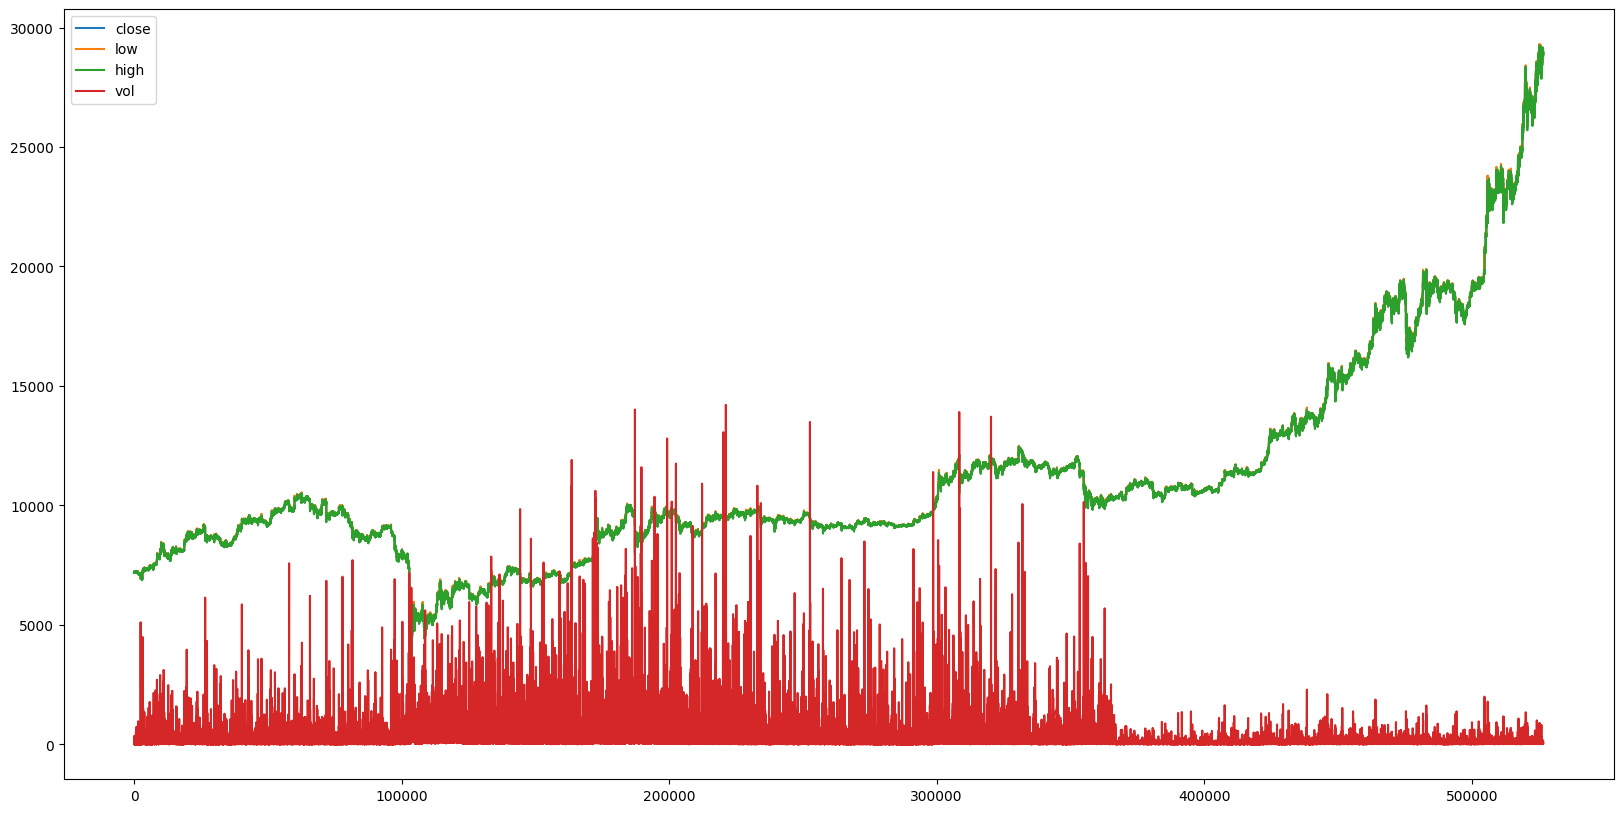

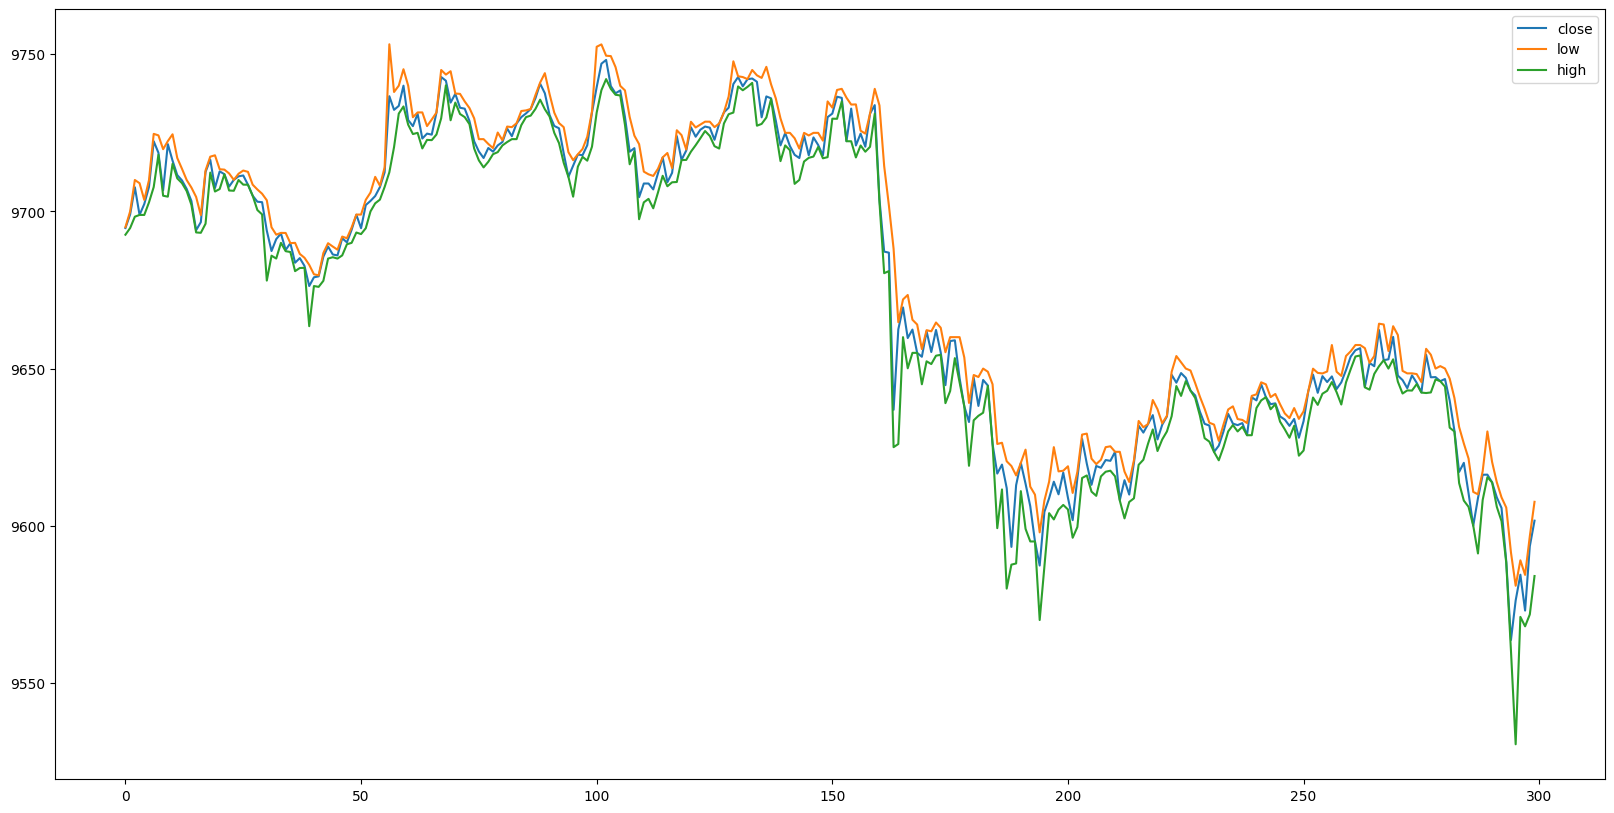

In [139]:

plt.figure(figsize=(20,10))
plt.plot(data, label="close")
plt.plot(data_high, label="low")
plt.plot(data_low, label="high")
plt.plot(data_vol, label="vol")
plt.legend()
plt.show()
plt.figure(figsize=(20,10))
plt.plot(data[200000:200300], label="close")
plt.plot(data_high[200000:200300], label="low")
plt.plot(data_low[200000:200300], label="high")
plt.legend()
plt.show()

In [97]:
def movAvg(data, winsize=1000):
    newData = []
    for d in range(len(data)):
        newData.append(np.mean(data[d:d+winsize]))
    return newData

In [98]:
difh = []
difl = []
for ii, price in enumerate(data):
    difh.append(data_high[ii]-price)
    difl.append(price-data_low[ii])

In [99]:
difhavg = movAvg(difh)
diflavg = movAvg(difl)

In [103]:
difhavg2 = movAvg(difhavg, winsize=100)
diflavg2 = movAvg(diflavg, winsize=100)

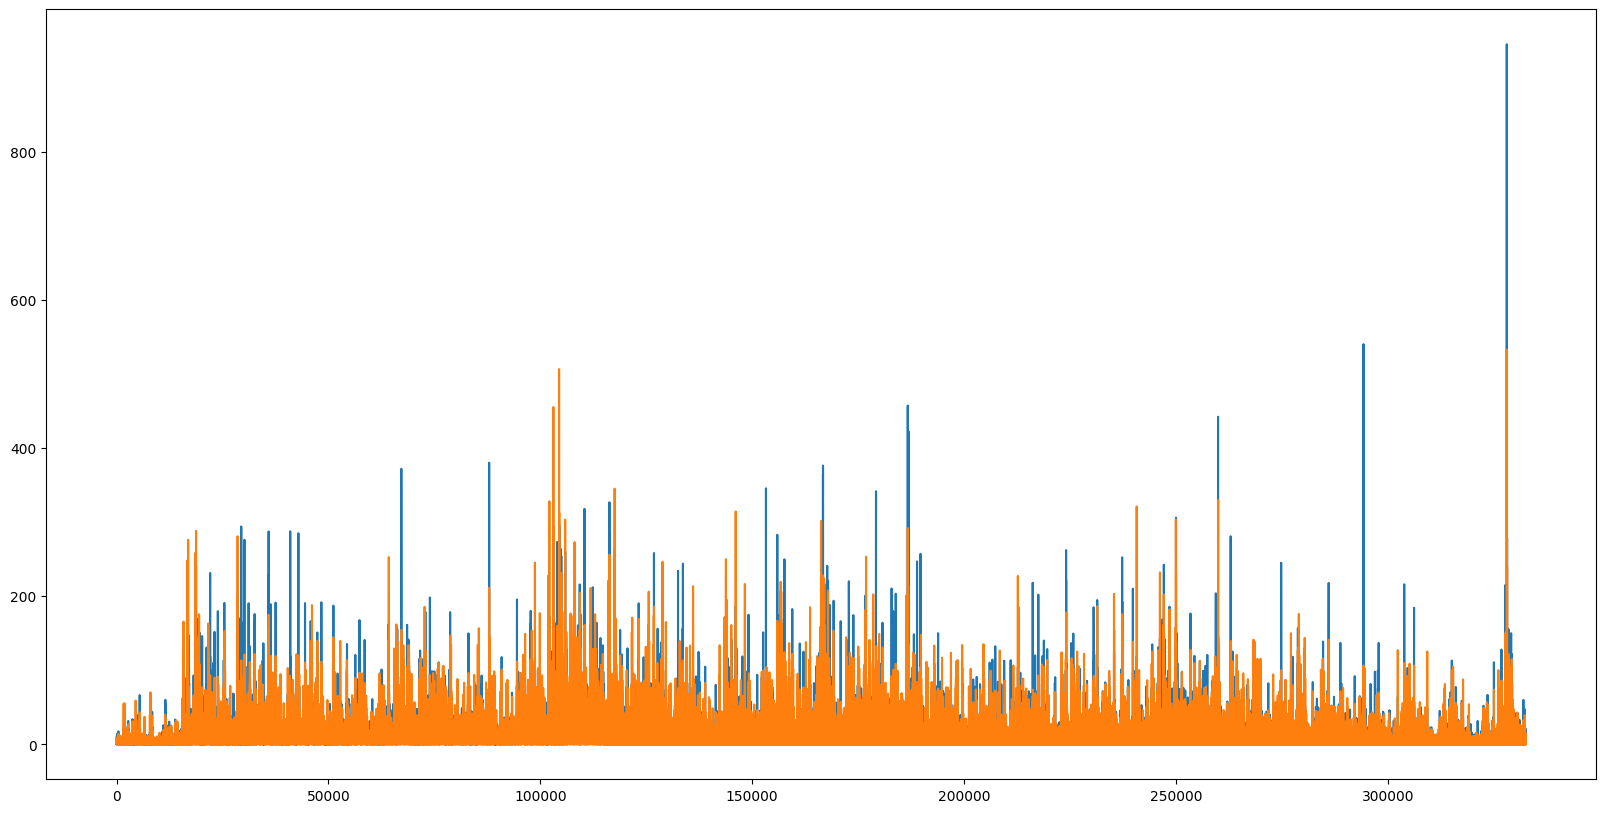

In [109]:
plt.figure(figsize=(20,10))
plt.plot(difh)
plt.plot(difl)

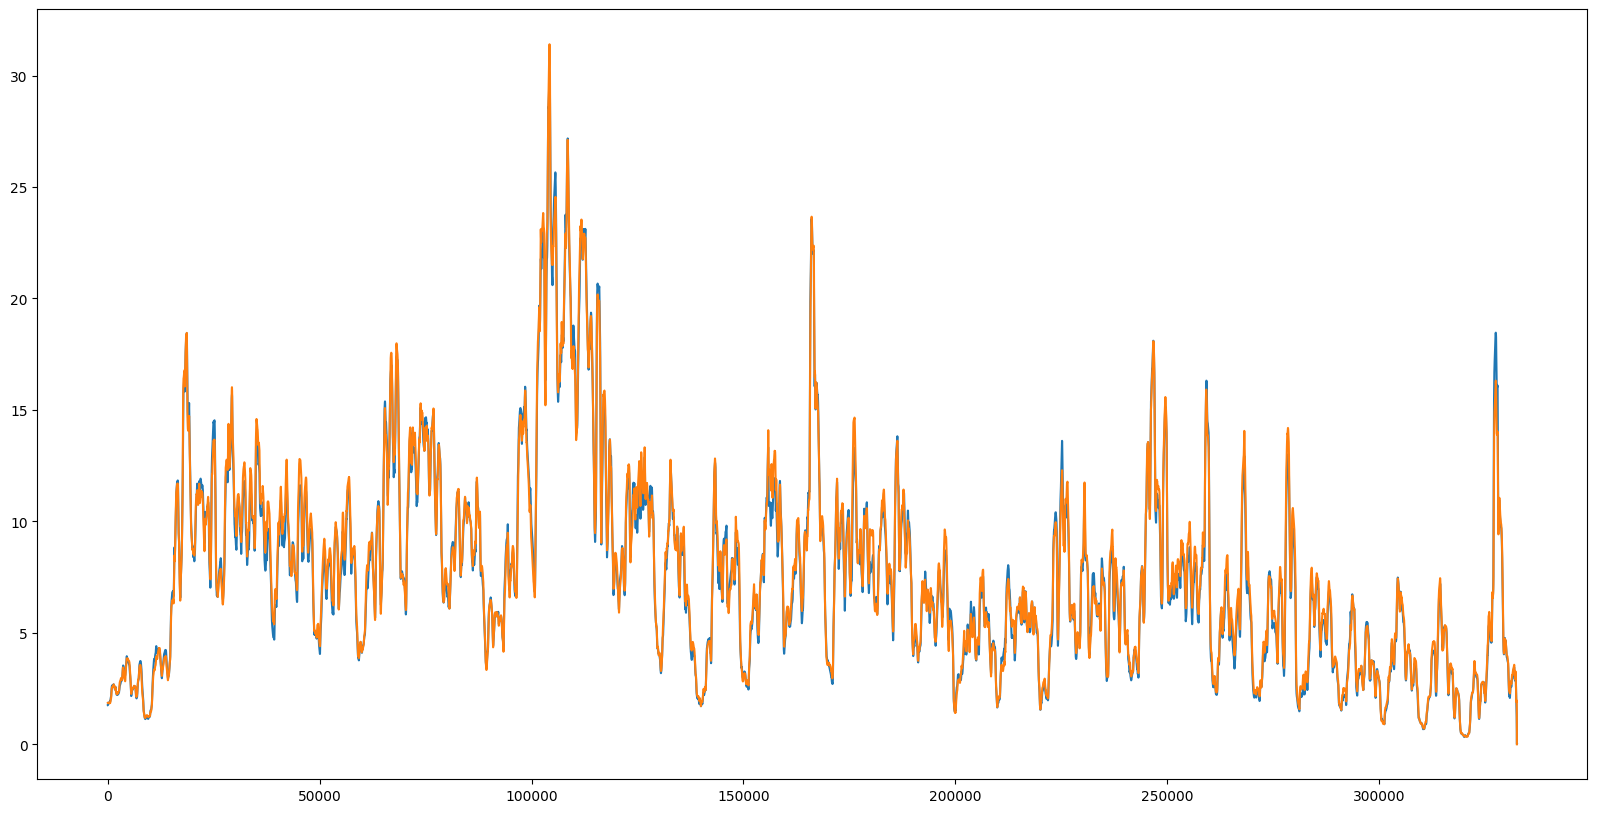

In [104]:
plt.figure(figsize=(20,10))
plt.plot(difhavg2)
plt.plot(diflavg2)